(api/01-fastapi)=
# API development 1

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/api/01-fastapi.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  {cite}`timviera`

## Introduction

In this chapter, we’ll cover the following main topics:
- Creating the first endpoint and running it locally
- Handling request parameters
- Customizing the response
- Structuring a bigger project with multiple routers

## Our first endpoint

The following creates a GET endpoint in the root path `/` using https://github.com/tiangolo/fastapi. 
The `hello_world` coroutine (see appendix) contains our route logic. This also called a **path operation** function. 
The return value is a dictionary that is automatically handled by FastAPI as a JSON response. Note that we use a decorator 
to specify the [HTTP method](https://developer.mozilla.org/en-US/docs/Web/HTTP/Methods) on the given route.

In [1]:
%%writefile ./01/main.py
import time
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
async def hello_world():
    return {"hello": "world"}

Overwriting ./01/main.py


Running in development mode allowing **reloads** of the server each time a code chage is made:

In [2]:
import subprocess

cmd = "uvicorn 01.main:app --host 0.0.0.0 --port 8000 --reload --log-level critical"
process = subprocess.Popen(cmd.split())

This means that the root path is in `http://0.0.0.0:8000/`. Here we use https://github.com/httpie/cli to simply our requests. The following command defaults to a GET request on localhost. Note that the output is a JSON object:

In [3]:
!http :8000/

HTTP/1.1 200 OK
content-length: 17
content-type: application/json
date: Sat, 06 Jul 2024 13:44:04 GMT
server: uvicorn

{
    "hello": "world"
}




**Remark.** An endpoint can have no return value (i.e. returns `None`). In this case, the response is an empty JSON (`null`).

FastAPI automatically provides interactive documentation:

```{figure} ../../img/apis/01-swagger.png
---
name: 01-swagger
width: 800px
---
Automatic documentation in `http://0.0.0.0:8000/docs`
```

## Request parameters

The main goal of an API is to provide a structured way to interact
with data. As such, it is crucial for the **client** to send information based on the 
response they need, such as path parameters, query parameters, body payloads, headers, and so on.
From the perspective of the **server**, request data should be validated based on the endpoint
logic.

### Path parameters

Unique resources can be accessed from paths using **path parameters**: 

In [4]:
%%writefile ./01/main.py
from fastapi import FastAPI

app = FastAPI()

@app.get("/users/{id}")
async def get_user(id: int):
    return {"id": id}

Overwriting ./01/main.py


**Remark.** Our paths always start with an `/` and does not end on a `/`.

Note that type hint is crucial. This can be seen in the JSON response where `id` is cast as int:

In [5]:
!http :8000/users/3

HTTP/1.1 200 OK
content-length: 8
content-type: application/json
date: Sat, 06 Jul 2024 13:37:26 GMT
server: uvicorn

{
    "id": 3
}




If the value cannot be cast to int, we get an error:

In [6]:
!http :8000/users/abc

HTTP/1.1 422 Unprocessable Entity
content-length: 147
content-type: application/json
date: Sat, 06 Jul 2024 13:37:26 GMT
server: uvicorn

{
    "detail": [
        {
            "input": "abc",
            "loc": [
                "path",
                "id"
            ],
            "msg": "Input should be a valid integer, unable to parse string as an integer",
            "type": "int_parsing"
        }
    ]
}




Note that we can apply validation on the path parameters. Multiple path parameters are also allowed:

In [7]:
%%writefile ./01/main.py
from enum import Enum
from typing import Annotated
from fastapi import FastAPI, Path

class UserType(str, Enum):
    STANDARD = "standard"
    ADMIN = "admin"


app = FastAPI()

@app.get("/users/{type}/{id}")
async def get_user(type: UserType, id: Annotated[int, Path(ge=0)]):
    return {"type": type, "id": id}

Overwriting ./01/main.py


**Remark.** Note the use of **type annotation** (Python 3.9+). 
This provides FastAPI with additional metadata about how we want the application should behave. 
The first type passed is the *actual type* of the parameter. Here we add the `Path` to validate
the path parameter to be at least 0. Finally, a parameter that has no default value is **required**.

Using enum constrains the user type to either `"standard"` or `"admin"`:

In [8]:
!http :8000/users/test/0

HTTP/1.1 422 Unprocessable Entity
content-length: 154
content-type: application/json
date: Sat, 06 Jul 2024 13:37:28 GMT
server: uvicorn

{
    "detail": [
        {
            "ctx": {
                "expected": "'standard' or 'admin'"
            },
            "input": "test",
            "loc": [
                "path",
                "type"
            ],
            "msg": "Input should be 'standard' or 'admin'",
            "type": "enum"
        }
    ]
}




Using a valid `type` value:

In [9]:
!http :8000/users/standard/3

HTTP/1.1 200 OK
content-length: 26
content-type: application/json
date: Sat, 06 Jul 2024 13:37:28 GMT
server: uvicorn

{
    "id": 3,
    "type": "standard"
}




In [10]:
!http :8000/users/admin/0

HTTP/1.1 200 OK
content-length: 23
content-type: application/json
date: Sat, 06 Jul 2024 13:37:29 GMT
server: uvicorn

{
    "id": 0,
    "type": "admin"
}




Trying an invalid id:

In [11]:
!http :8000/users/admin/-1

HTTP/1.1 422 Unprocessable Entity
content-length: 141
content-type: application/json
date: Sat, 06 Jul 2024 13:37:30 GMT
server: uvicorn

{
    "detail": [
        {
            "ctx": {
                "ge": 0
            },
            "input": "-1",
            "loc": [
                "path",
                "id"
            ],
            "msg": "Input should be greater than or equal to 0",
            "type": "greater_than_equal"
        }
    ]
}




**Remark.** For a string path parameter, validation such as the following exists (regex also possible):

```
username: Annotated[str, Path(min_length=4, max_length=16)]
```

### Query parameters

Note that path parameters are required and used to identify unique resources. In contrast, **query parameters** are optional and commonly used on read endpoints to  apply pagination, a filter, a sorting order, or selecting fields. The following implements two optional query parameters for pagination:

In [12]:
%%writefile ./01/main.py
from fastapi import FastAPI

app = FastAPI()

@app.get("/users")
async def get_users(offset: int = 0, limit: int = 100):
    return {"offset": offset, "limit": limit}

Overwriting ./01/main.py


In [13]:
!http "http://localhost:8000/users?offset=5&limit=10"

HTTP/1.1 200 OK
content-length: 23
content-type: application/json
date: Sat, 06 Jul 2024 13:37:31 GMT
server: uvicorn

{
    "limit": 10,
    "offset": 5
}




**Remark.** HTTPie uses `param==value` syntax for query parameters:

In [14]:
!http :8000/users offset==5 limit==10

HTTP/1.1 200 OK
content-length: 23
content-type: application/json
date: Sat, 06 Jul 2024 13:37:31 GMT
server: uvicorn

{
    "limit": 10,
    "offset": 5
}




The following example shows selecting fields using query parameters:

In [15]:
%%writefile ./01/main.py
from typing import Annotated
from fastapi import FastAPI, Query

app = FastAPI()

# Sample data
items = [
    {"id": 1, "name": "Item 1", "description": "Description 1", "price": 10.0},
    {"id": 2, "name": "Item 2", "description": "Description 2", "price": 20.0},
]

allowed_fields = {"id", "name", "description", "price"}


@app.get("/items")
def read_items(fields: Annotated[list[str], Query()] = list(allowed_fields)):
    result = []
    for item in items:
        filtered_item = {field: item[field] for field in fields if field in item}
        result.append(filtered_item)
        
    return result

Overwriting ./01/main.py


The allowed fields have a default value that are conveniently listed in the docs:

```{figure} ../../img/apis/01-swagger-list-string.png
---
name: 01-swagger-list-string
width: 800px
---
```

Default behavior:

In [16]:
!http :8000/items

HTTP/1.1 200 OK
content-length: 137
content-type: application/json
date: Sat, 06 Jul 2024 13:37:33 GMT
server: uvicorn

[
    {
        "description": "Description 1",
        "id": 1,
        "name": "Item 1",
        "price": 10.0
    },
    {
        "description": "Description 2",
        "id": 2,
        "name": "Item 2",
        "price": 20.0
    }
]




Filtering:

In [17]:
!http :8000/items fields==id fields==name

HTTP/1.1 200 OK
content-length: 51
content-type: application/json
date: Sat, 06 Jul 2024 13:37:33 GMT
server: uvicorn

[
    {
        "id": 1,
        "name": "Item 1"
    },
    {
        "id": 2,
        "name": "Item 2"
    }
]




**Remark.** Validation functionality in `Path` are also available for `Query`. In the above code, we can also raise `HTTPException` (imported from the `fastapi` library) if the given field is not in the allowed fields:

```python
allowed_fields = {"id", "name", "description", "price"}

@app.get("/items")
def read_items(fields: Annotated[list[str], Query()] = list(allowed_fields)):
    for field in fields:
        if field not in allowed_fields:
            raise HTTPException(status_code=400, detail=f"Field '{field}' is not valid")
    
    ...
```

Note that `fields` will never be empty, since if do not provide a field query, then it defaults to the allowed fields.

### Request body

The body is the part of the HTTP request containing raw data representing documents, files, or
form submissions. In a REST API, it is usually encoded in JSON and used to create structured objects
in a database. Note that we use a POST request to send data in a request body:

In [18]:
%%writefile ./01/main.py
from typing import Annotated
from fastapi import FastAPI, Body

app = FastAPI()

@app.post("/users")
async def create_user(name: Annotated[str, Body()], age: Annotated[int, Body(ge=0)]):
    return {"name": name, "age": age}

Overwriting ./01/main.py


We have to specify POST since HTTPie defaults to GET. The syntax for body fields is `field=value`:

In [19]:
!http -v POST :8000/users name=John age=0

POST /users HTTP/1.1
Accept: application/json, */*;q=0.5
Accept-Encoding: gzip, deflate
Connection: keep-alive
Content-Length: 28
Content-Type: application/json
Host: localhost:8000
User-Agent: HTTPie/3.2.2

{
    "age": "0",
    "name": "John"
}


HTTP/1.1 200 OK
content-length: 23
content-type: application/json
date: Sat, 06 Jul 2024 13:37:34 GMT
server: uvicorn

{
    "age": 0,
    "name": "John"
}




The `-v` flag for HTTPie allows us to see the JSON payload we sent. Both fields are strings, but age is later cast as int once processed. Since each field is required, we get a 422 status error response if we send a request with a missing field. Note that request body fields also have validation functionality same as query and path parameters above.

```{margin}
https://github.com/pydantic/pydantic
```

**Schemas.** In practice, we will reuse the structure of the data between multiple endpoints (e.g. a document, or a user). Hence, it would be nice to define a **schema** for the request body. This makes it easy to read and refactor code. FastAPI uses **Pydantic models** to accomplish this. Pydantic is a library for data validation and is based on classes and type hints which makes it ideal for this use case. 

Modifying the above code:

In [20]:
%%writefile ./01/main.py
from fastapi import FastAPI
from pydantic import BaseModel, Field

class User(BaseModel):
    name: str
    age: int = Field(ge=0)

app = FastAPI()

@app.post("/users")
async def create_user(user: User):
    return user

Overwriting ./01/main.py


Note that Pydantic model output is automatically converted to JSON:

In [21]:
!http POST :8000/users name=John age=1

HTTP/1.1 200 OK
content-length: 23
content-type: application/json
date: Sat, 06 Jul 2024 13:37:35 GMT
server: uvicorn

{
    "age": 1,
    "name": "John"
}




Testing **field validation**:

In [22]:
!http POST :8000/users name=John age=-1

HTTP/1.1 422 Unprocessable Entity
content-length: 142
content-type: application/json
date: Sat, 06 Jul 2024 13:37:35 GMT
server: uvicorn

{
    "detail": [
        {
            "ctx": {
                "ge": 0
            },
            "input": "-1",
            "loc": [
                "body",
                "age"
            ],
            "msg": "Input should be greater than or equal to 0",
            "type": "greater_than_equal"
        }
    ]
}




**Remark.** 
Each individual attribute can be accessed by using the dot notation, such as `user.name`.
Field filtering can be done with `item.model_dump(include=set(fields))` where `item` is a Pydantic model. 
We can use multiple models as well as a single body parameter for a property that is not part of any model:

In [23]:
%%writefile ./01/main.py
from typing import Annotated
from fastapi import FastAPI, Body
from pydantic import BaseModel, Field

class User(BaseModel):
    name: str
    age: int = Field(ge=0)

app = FastAPI()

@app.post("/users")
async def create_user(user: User, priority: Annotated[int, Body()]):
    return {"user": user, "priority": priority}

Overwriting ./01/main.py


Here we have to pipe the more complex JSON request:

In [24]:
!http POST :8000/users <<< '{"user": {"name": "John", "age": 3}, "priority": 3}'


HTTP/1.1 200 OK
content-length: 45
content-type: application/json
date: Sat, 06 Jul 2024 13:37:37 GMT
server: uvicorn

{
    "priority": 3,
    "user": {
        "age": 3,
        "name": "John"
    }
}




**Remark.** The above examples show that schemas ensures that data is validated as well as properly serialized between different formats. Schemas are also used when automatically generating API documentation.

### File uploads

FastAPI provides a parameter function `File` that enables file uploads. This is a common requirement for web applications (e.g. image, audio, or document upload). The approach is as usual: we can use `file: Annotated[bytes, File()]` where `File` is the parameter function provided by FastAPI. This stores the data in memory, and so may not be ideal for large files. 

FastAPI provides an `UploadFile` class will store the data in memory up to a certain threshold, then will automatically store it on disk in a **temporary location**. This allows you to accept much larger files without running out of memory. Furthermore, the object instance exposes useful metadata (e.g. `file.content_type`) and a file-like interface (e.g. `file.read`, `file.write`):

In [48]:
%%writefile ./01/main.py
import numpy as np
from PIL import Image
from fastapi import FastAPI, UploadFile

app = FastAPI()

@app.post("/files")
async def upload_file(file: UploadFile):
    img = Image.open(file.file)
    return {
        "filename": file.filename,
        "content_type": file.content_type,
        "size": file.size,
        "dims": np.array(img).shape, 
    }

Overwriting ./01/main.py


HTTPie upload syntax. Note curl is a bit different with `file=@` instead of `file@`:

In [26]:
!http --form POST :8000/files file@./assets/tom.jpeg

HTTP/1.1 200 OK
content-length: 84
content-type: application/json
date: Sat, 06 Jul 2024 13:37:38 GMT
server: uvicorn

{
    "content_type": "image/jpeg",
    "dims": [
        923,
        923,
        3
    ],
    "filename": "tom.jpeg",
    "size": 130055
}




**Remark.** The content type is particularly useful. The upload can be rejected if the server receives an unexpected filetype. Multiple uploads is also possible:

```python
@app.post("/files")
async def upload_files(files: list[UploadFile]):
    return [
        {
            "filename": file.filename,
            "content_type": file.content_type,
            "size": file.size,
            "dims": np.array(Image.open(file.file)).shape, 
        }
        for file in files
    ]
```

Multiple upload request using HTTPie:

```
http --form POST :8000/files files@xgboost-parallel.png files@xgboost-contour.png files@workflow.png
```

Equivalent execution in the docs UI:

```{figure} ../../img/apis/01-swagger-file-uploads.png
---
name: 01-swagger-file-uploads
width: 800px
---
Multiple file uploads in the docs UI.
```


### Form data

HTML forms (`<form></form>`) typically sends the data to a server using a different encoding for that data (i.e. different from JSON). Form data can be handled by annotating with `Form()`:

In [27]:
%%writefile ./01/main.py
from typing import Annotated
from fastapi import FastAPI, Form

app = FastAPI()

@app.post("/users")
async def create_user(name: Annotated[str, Form()], age: Annotated[int, Form()]):
    return {"name": name, "age": age}

Overwriting ./01/main.py


Request syntax:

In [28]:
!http -v --form :8000/users name=John age=30

POST /users HTTP/1.1
Accept: */*
Accept-Encoding: gzip, deflate
Connection: keep-alive
Content-Length: 16
Content-Type: application/x-www-form-urlencoded; charset=utf-8
Host: localhost:8000
User-Agent: HTTPie/3.2.2

name=John&age=30


HTTP/1.1 200 OK
content-length: 24
content-type: application/json
date: Sat, 06 Jul 2024 13:37:39 GMT
server: uvicorn

{
    "age": 30,
    "name": "John"
}




### Headers and cookies

FastAPI automatically retrieves **headers** by converting to lowercase and replacing `-` with `_`. 
FastAPI also provides a way to get **cookies** which are a special type of header used to save user state in a browser between visits. These will be helpful in implementing common authentication schemes.

In [4]:
%%writefile ./01/main.py
from typing import Annotated
from fastapi import FastAPI, Cookie, Header

app = FastAPI()

@app.get("/cookie")
async def get_cookie(hello: Annotated[str | None, Cookie()] = None):
    return {"hello": hello}

@app.get("/header")
async def get_header(user_agent: Annotated[str, Header()], connection: Annotated[str, Header()]):
    return {"user_agent": user_agent, "connection": connection}

Overwriting ./01/main.py


Sample requests:

In [47]:
!http :8000/cookie

HTTP/1.1 200 OK
content-length: 14
content-type: application/json
date: Sat, 06 Jul 2024 13:42:47 GMT
server: uvicorn

{
    "hello": null
}




In [31]:
!http -v :8000/header

GET /header HTTP/1.1
Accept: */*
Accept-Encoding: gzip, deflate
Connection: keep-alive
Host: localhost:8000
User-Agent: HTTPie/3.2.2



HTTP/1.1 200 OK
content-length: 55
content-type: application/json
date: Sat, 06 Jul 2024 13:37:40 GMT
server: uvicorn

{
    "connection": "keep-alive",
    "user_agent": "HTTPie/3.2.2"
}




### Request object

The **request object** exposes raw data associated with a request:

In [32]:
%%writefile ./01/main.py
from fastapi import FastAPI, Request

app = FastAPI()

@app.post("/")
async def get_request_object(request: Request):
    return {
        "path": request.url.path,
        "hostname": request.base_url.hostname,
        "port": request.base_url.port,
    }

Overwriting ./01/main.py


As usual, we simply had to declare an argument hinted with
the `Request` class.

In [33]:
!http POST :8000/

HTTP/1.1 200 OK
content-length: 47
content-type: application/json
date: Sat, 06 Jul 2024 13:37:42 GMT
server: uvicorn

{
    "hostname": "localhost",
    "path": "/",
    "port": 8000
}




**Setting headers.** The `Response` object exposes a set of properties including the `headers` dictionary. Note that `response_model` and `status_code` can still be used. As usual, FastAPI does this using type hints.

In [5]:
%%writefile ./01/main.py
import time
from typing import Annotated
from fastapi import FastAPI, Response, Cookie, Request

app = FastAPI()

@app.get("/set-header")
async def custom_header(response: Response):
    response.headers["Custom-Header"] = "Custom-Header-Value"
    return {"hello": "world"}

@app.get("/set-cookie")
async def custom_cookie(request: Request, response: Response, cookie_name: Annotated[str | None, Cookie()] = None):
    response.set_cookie("cookie-name", "cookie-value", max_age=86400)  # seconds
    return {
        "cookie_value": request.cookies.get("cookie-name"), 
        "request_headers": request.headers, 
        "response_headers": response.headers,
    }

@app.get("/cookie")
async def get_cookie(hello: Annotated[str | None, Cookie()] = None):
    return {"hello": hello}

Overwriting ./01/main.py


Notice the custom header:

In [35]:
!http :8000/set-header

HTTP/1.1 200 OK
content-length: 17
content-type: application/json
custom-header: Custom-Header-Value
date: Sat, 06 Jul 2024 13:37:43 GMT
server: uvicorn

{
    "hello": "world"
}




In [36]:
!http :8000/set-cookie

HTTP/1.1 200 OK
content-length: 266
content-type: application/json
date: Sat, 06 Jul 2024 13:37:43 GMT
server: uvicorn
set-cookie: cookie-name=cookie-value; Max-Age=86400; Path=/; SameSite=lax

{
    "cookie_value": null,
    "request_headers": {
        "accept": "*/*",
        "accept-encoding": "gzip, deflate",
        "connection": "keep-alive",
        "host": "localhost:8000",
        "user-agent": "HTTPie/3.2.2"
    },
    "response_headers": {
        "set-cookie": "cookie-name=cookie-value; Max-Age=86400; Path=/; SameSite=lax"
    }
}




<br>

**Setting cookies.** Cookies are useful when you want to maintain the user's state within the browser
between each of their visits. The `Response` object exposes a `set_cookie` method used above to set a cookie named `cookie-name` with `cookie-value` that is valid for 86,400 seconds.

In [37]:
!http :8000/set-cookie

HTTP/1.1 200 OK
content-length: 266
content-type: application/json
date: Sat, 06 Jul 2024 13:37:44 GMT
server: uvicorn
set-cookie: cookie-name=cookie-value; Max-Age=86400; Path=/; SameSite=lax

{
    "cookie_value": null,
    "request_headers": {
        "accept": "*/*",
        "accept-encoding": "gzip, deflate",
        "connection": "keep-alive",
        "host": "localhost:8000",
        "user-agent": "HTTPie/3.2.2"
    },
    "response_headers": {
        "set-cookie": "cookie-name=cookie-value; Max-Age=86400; Path=/; SameSite=lax"
    }
}




Checking if cookie has been set in Chrome developer tools:

```{figure} ../../img/apis/01-fastapi-cookie-set.png
---
name: 01-fastapi-cookie-set
width: 800px
---
```

## Customizing the response

In the previous examples, our endpoints simply returned a dictionary or Pydantic object which is enough for FastAPI to return a JSON response. Most of the time, we want to customize the response further: add status code, raising errors, and setting cookies. We will consider multiple ways of doing this with increasing customization.

### Decorator parameters

The following modifies the status code from `200 OK` to `201 Created` via the path decorator. Note that the specified status code only applies if no errors were encountered. Other status codes are `204 No content` for a delete endpoint (i.e. `@app.delete`)

In [38]:
%%writefile ./01/main.py
from pydantic import BaseModel
from fastapi import FastAPI, status

class Post(BaseModel):
    title: str

app = FastAPI()

@app.post("/posts", status_code=status.HTTP_201_CREATED)
async def create_post(post: Post):
    return post

Overwriting ./01/main.py


Note that response status is `201 Created`:

In [39]:
!http POST :8000/posts title="Post"

HTTP/1.1 201 Created
content-length: 16
content-type: application/json
date: Sat, 06 Jul 2024 13:37:45 GMT
server: uvicorn

{
    "title": "Post"
}




### Response model

The main use case in FastAPI is to directly return a Pydantic model that is automatically serialized to JSON. However, it is often the case that there are some differences between
the input data, the data you store in your database, and the data you want to show to the end user. For example, some fields are private or only used in internal logic, or only used temporarily.

In [40]:
%%writefile ./01/main.py
from pydantic import BaseModel
from fastapi import FastAPI, status

class Post(BaseModel):
    title: str
    views: int = 0

class PublicPost(BaseModel):
    title: str

posts = {
    0: Post(title="Hello", nb_views=100),
}

app = FastAPI()

@app.get("/posts/{id}", response_model=PublicPost)
async def get_post(id: int):
    return posts[id]

Overwriting ./01/main.py


Observe that the `views` field is hidden even when the function output is `Post`:

In [41]:
!http :8000/posts/0

HTTP/1.1 200 OK
content-length: 17
content-type: application/json
date: Sat, 06 Jul 2024 13:37:46 GMT
server: uvicorn

{
    "title": "Hello"
}




This is taken into account in the docs UI:

```{figure} ../../img/apis/01-swagger-response-model.png
---
name: 01-swagger-response-model
width: 800px
---
```

### Response parameter

The body and status code are not the only interesting parts of an HTTP response. Sometimes, it might
be useful to return some custom headers or set cookies. This can be done dynamically within the path operation logic by **injecting** the `Response` object as an argument of the path function.

## Appendix: Asynchronous I/O 

I/O operations such as reading from disk or network requests are million times slower than reading
from RAM or processing instructions.
The **asynchronous paradigm** is a way to make I/O operations non-blocking and allow the program to perform other
tasks while the slow read or write operation is ongoing.
For web servers, waiting on I/O operations could be an opportunity to perform other tasks.
This has been achieved through the concept of an **event loop**. The event loop orchestrates
all the asynchronous tasks sent to it. When data is available or when the write operation
is done for one of those tasks, it will ping the main program so that it can perform the next operations.

In [42]:
import time
import asyncio

async def main(delay: int = 1):
    print("Hello...")
    if delay > 0:
        await asyncio.sleep(delay)
    print("... World!")

await main()

Hello...
... World!


This runs for about 1 sec. The `async` keyword indicates that `main` is an asynchronous function or **coroutine**. This allows us to use `await` inside it. Note that `asyncio.sleep` is also a coroutine that is the asynchronous version of `time.sleep`. Prefixing with `await` sends it to the event loop, but also means that we want to go back to it once it completes, and continue the next operations (i.e. the next print statement). 
Hence, such operations are said to be **non-blocking**.
This allows the event loop to process other tasks in the mean time:

In [43]:
async def other():
    print("<☺>")

await asyncio.gather(main(), other())

Hello...
<☺>
... World!


[None, None]

Note that `gather` collects the outputs of each coroutine in a list which we await. The coroutines are executed **concurrently**. If `main` does not have the I/O operation, then it continues to block the event loop until it has completed processing. Regular operations such as computations are blocking and will block the event loop. Usually, this is not a problem since those
operations are fast (as is the case here):

In [44]:
await asyncio.gather(main(0), other())

Hello...
... World!
<☺>


[None, None]

The only operations that are non-blocking are I/O operations designed
to work asynchronously. This is different from **multiprocessing** where operations are executed on
child processes, so blocking the main process clearly does not happen. Because of this, we will have to 
be careful when choosing a third-party library for interacting with databases, APIs, and so on, if they are 
not designed to work asynchronously.

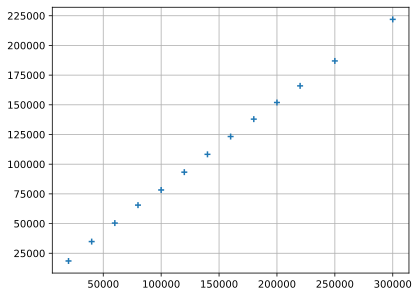

In [11]:
x = [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 250000, 300000]
y = [18500, 34831, 50431, 65537.45, 78287.45, 93287.45, 108287.45, 123287.45, 137943.30, 151943, 165943.30, 186943.30, 221943.30]

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.grid()
plt.scatter(x, y, zorder=3, marker="+");

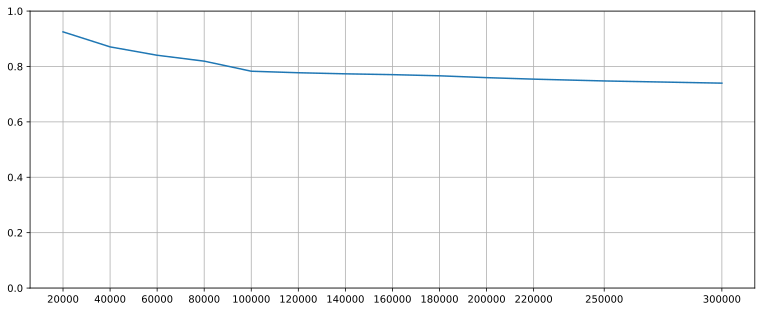

In [25]:
import numpy as np
plt.figure(figsize=(13, 5))
plt.plot(x, np.array(y) / np.array(x))
plt.xticks(x)
plt.ylim(0, 1)
plt.grid();

In [176]:
AL = 2500
MR = 160000

DR = MR * 12 / 251
HR = DR / 8
ND = 4 * HR * 0.15
monthly = MR + 20 * ND
print(f"Gross monthly: \t{monthly + AL:.2f}")
taxed_monthly = 131893.02   # https://taxcalculatorphilippines.com/

special_holiday = 4 * HR * (4 * 0.3 + 4 * 0.5)
legal_holiday =  14 * HR * (4 * 1.0 + 4 * 1.3)
taxed_xmas = 90000 + (MR - 90000) * 0.80
taxed_holiday = (special_holiday + legal_holiday) * 0.77

net_annual = (taxed_monthly + AL) * 12
net_annual += taxed_holiday
net_annual += taxed_xmas

print("Net:")
print(f"   Monthly: \t{(taxed_monthly + AL):.2f} / {(taxed_monthly + AL) / 2:.2f} (cutoff)")
print(f"   13th month: \t{taxed_xmas:.2f}")
print(f"   Holidays: \t{taxed_holiday:.2f}")
print(f"   Allowance: \t {AL * 12:.2f}")
print(f"\nTotal (year): \t{net_annual:.2e}")
net_annual_relx = net_annual

Gross monthly: 	173974.10
Net:
   Monthly: 	134393.02 / 67196.51 (cutoff)
   13th month: 	146000.00
   Holidays: 	104253.71
   Allowance: 	 30000.00

Total (year): 	1.86e+06


In [181]:
AL = 4500
MR = 93000
DR = MR * 12 / 240
ND = DR * 0.0
monthly = MR + 20 * ND
print(monthly)
taxed_monthly = 75043.70   # https://taxcalculatorphilippines.com/
special_holiday = 4 * DR * (4 * 0.0 + 4 * 0.0) / 8
legal_holiday =  14 * DR * (4 * 0.0 + 4 * 0.0) / 8
xmas = 90000 + (MR - 90000) * 0.80
taxed_holiday = (special_holiday + legal_holiday) * 0.77
annual_income = (taxed_monthly + AL) * 12
annual_income += taxed_holiday
annual_income += xmas
print("Net income:")
print(f"\tMonthly: \t{taxed_monthly + AL:.2f} / {(taxed_monthly + AL) / 2:.2f} (cutoff)")
print(f"\t13th month: \t{xmas:.2f}")
print(f"\tHolidays: \t{taxed_holiday:.2f}")
print(f"\nNet yearly: {annual_income:.2e}")
annual_income_ubiq = annual_income

93000.0
Net income:
	Monthly: 	79543.70 / 39771.85 (cutoff)
	13th month: 	92400.00
	Holidays: 	0.00

Net yearly: 1.05e+06


In [154]:
annual_income_relx/12, annual_income_ubiq/12, annual_income_relx - annual_income_ubiq

(155247.4954316069, 119537.45, 428520.5451792828)

---

■